In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(caret))
suppressMessages(library(patchwork))

In [ ]:
get_sensitivity <- function(method){    
    sensitivity <- lapply(c(0:9), function(i){
        df <- read.csv(glue::glue("../benchmarking/{method}/svgs/rep_{i}.csv"), row.names=1)
        colnames(df) <- c("adjusted_pvalue", "spatially_variable")
        df$pred = ifelse(df$adjusted_pvalue < 0.05, 1, 0)    
        conf_matrix<-table(df$pred, df$spatially_variable)
        return(sensitivity(conf_matrix))
    
    }) %>% unlist() %>%as.data.frame()
    
    colnames(sensitivity) <- c("sensitivity")
    sensitivity$method <- method
    
    return(sensitivity)

}

In [ ]:
get_specificity <- function(method){    
    specificity <- lapply(c(0:9), function(i){
        df <- read.csv(glue::glue("../benchmarking/{method}/svgs/rep_{i}.csv"), row.names=1)
        colnames(df) <- c("adjusted_pvalue", "spatially_variable")
        df$pred = ifelse(df$adjusted_pvalue < 0.05, 1, 0)    
        conf_matrix<-table(df$pred, df$spatially_variable)
        return(specificity(conf_matrix))
    
    }) %>% unlist() %>%as.data.frame()
    
    colnames(specificity) <- c("specificity")
    specificity$method <- method
    
    return(specificity)

}

In [2]:
get_accuracy <- function(method){    
    acc <- lapply(c(0:9), function(i){
        df <- read.csv(glue::glue("../benchmarking/{method}/svgs/rep_{i}.csv"), row.names=1)
        colnames(df) <- c("adjusted_pvalue", "spatially_variable")
        df$pred = ifelse(df$adjusted_pvalue < 0.05, 1, 0)
        df$correct_pred = df$spatially_variable == df$pred
        
        return(sum(df$correct_pred) / nrow(df))  
        
    }) %>% unlist() %>%as.data.frame()
    
    colnames(acc) <- c("accuracy")
    acc$method <- method
    
    return(acc)

}

In [3]:
method_list = c("MoranI", "scGCO", "SpatialDE", "SOMDE", "SPARK", "SPARK-X")

df_acc <- lapply(method_list, 
                 function(method){return(get_accuracy(method))}) %>% 
    Reduce(rbind, .) %>%
    group_by(method) %>%
    summarise(mean = mean(accuracy), sd = sd(accuracy))

df_sen <- lapply(method_list, 
                 function(method){return(get_sensitivity(method))}) %>% 
    Reduce(rbind, .) %>%
    group_by(method) %>%
    summarise(mean = mean(sensitivity), sd = sd(sensitivity))

df_spe <- lapply(method_list, 
                 function(method){return(get_specificity(method))}) %>% 
    Reduce(rbind, .) %>%
    group_by(method) %>%
    summarise(mean = mean(specificity), sd = sd(specificity))

In [4]:
cols=ArchR:::ArchRPalettes$stallion
cols

1         2         3         4         5         6         7         8 
"#D51F26" "#272E6A" "#208A42" "#89288F" "#F47D2B" "#FEE500" "#8A9FD1" "#C06CAB" 
       19        10        11        12        13        14        15        16 
"#E6C2DC" "#90D5E4" "#89C75F" "#F37B7D" "#9983BD" "#D24B27" "#3BBCA8" "#6E4B9E" 
       17        18         9        20 
"#0C727C" "#7E1416" "#D8A767" "#3D3D3D"

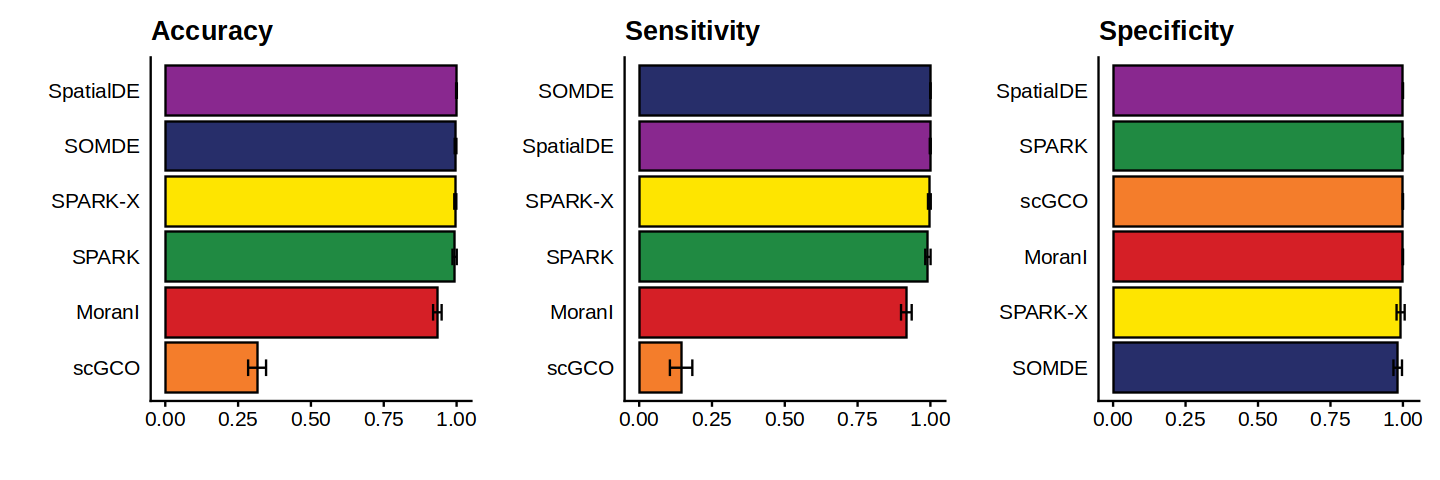

In [5]:
options(repr.plot.height = 4, repr.plot.width = 12)

cols <- c("MoranI" = "#D51F26",
         "SOMDE" = "#272E6A",
         "SPARK" = "#208A42",
         "SpatialDE" = "#89288F",
         "scGCO" = "#F47D2B",
         "SPARK-X" = "#FEE500")

p1 <- ggplot(data=df_acc, aes(x = reorder(method, mean), y = mean)) +
    geom_bar(aes(fill = method), stat = "identity", color="black") +
    geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
    scale_fill_manual(values = cols) +
    xlab("") + ylab("") + ggtitle("Accuracy") +
    theme_cowplot() +
    theme(legend.position = "none",
         axis.ticks.y = element_blank()) +
    coord_flip()

p2 <- ggplot(data=df_sen, aes(x = reorder(method, mean), y = mean)) +
    geom_bar(aes(fill = method), stat = "identity", color="black") +
    geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
    scale_fill_manual(values = cols) +
    xlab("") + ylab("") + ggtitle("Sensitivity") +
    theme_cowplot() +
    theme(legend.position = "none",
         axis.ticks.y = element_blank()) +
    coord_flip()

p3 <- ggplot(data=df_spe, aes(x = reorder(method, mean), y = mean)) +
    geom_bar(aes(fill = method), stat = "identity", color="black") +
    geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
    scale_fill_manual(values = cols) +
    xlab("") + ylab("") + ggtitle("Specificity") +
    theme_cowplot() +
    theme(legend.position = "none",
         axis.ticks.y = element_blank()) +
    coord_flip()

p1 + p2 + p3